Autor: Rodrigo Stuckert. Data: 2020-08-06

# Análise da Covid-19 no Distrito Federal

Este código foi feito para analisar os casos da covid-19 no Distrito Federal (DF). Os dados aqui utilizados são referentes ao dia 2020-08-05 18:00, e foram extraídos a partir da seguinte página: https://covid19.ssp.df.gov.br/extensions/covid19/covid19.html#/

Cabe salientar que, a partir do dia 2020-07-09, houve uma alteração na disposição dos dados. Removeu-se o número de identificação de cada pessoa (**id**); adicionou-se uma nova variável, **dataPrimeirosintomas**, indicando o início dos sintomas; e, por fim, substitui-se a variável **Estado de Saúde** por uma **Óbito**, indicando se a pessoa faleceu até aquele dia, ou não. De fato, para fins do painel de dados próprio, a Secretaria de Saúde (SESDF) considera como casos recuperados aqueles em que a pessoa não foi a óbito ou se internou após sete dias do diagnóstico. 

## Extração dos dados

Os pacotes aqui utilizados foram o dplyr e lubridate, para manipulação dos dados; e o ggplot2 e gridExtra, para a elaboração dos gráficos. A função "options(warn = -1)" desativa as mensagens de aviso do R. Para voltar ao normal, basta usar "options(warn = 0)"

In [1]:
options(warn = -1)
library(dplyr)
library(lubridate) # Manipular datas
library(ggplot2)
library(gridExtra) # Plotar dois gráficos em uma única imagem
options(warn = 0)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



Os dados estão no arquivo "dados-abertos.csv", dentro do diretório "datasets". Caso você queira baixar os dados mais recentes, no lugar, substitua essa referência pelo link mencionado abaixo. É importante ter em mente aqui que pode haver problemas de compatibilidade futuramente, caso a Secretaria de Saúde do DF (SESDF) eventualmente altere a disposição dos dados.

In [2]:
#file <- "https://covid19.ssp.df.gov.br/resources/dados/dados-abertos.csv"
file <- "datasets/dados-abertos.csv"
df <- data.table::fread(file, encoding = "UTF-8", 
                        col.names = c("Data", "DataCadastro", "Sexo",
                                      "FaixaEtaria", "RA", "UF", "Obito", "DataPrimeirosintomas",
                                      "Pneumopatia", "Nefropatia", "DHematologica",
                                      "DistMetabolico", "Imunopressao", "Obesidade",
                                      "Outros", "Cardiovasculopatia"),
                        colClasses = list(factor= c(3, 6)) # Colunas Sexo e UF como factors
                        )

#### Verificando a importação do arquivo.

In [3]:
str(df) # Estrutura

Classes 'data.table' and 'data.frame':	84761 obs. of  16 variables:
 $ Data                : chr  "21/07/2020" "21/07/2020" "21/07/2020" "21/07/2020" ...
 $ DataCadastro        : chr  "18/03/2020" "18/03/2020" "18/03/2020" "18/03/2020" ...
 $ Sexo                : Factor w/ 2 levels "Feminino","Masculino": 2 2 2 2 1 1 1 1 2 1 ...
 $ FaixaEtaria         : chr  "50 a 59 anos" "50 a 59 anos" "40 a 49 anos" ">= 60 anos" ...
 $ RA                  : chr  "Plano Piloto" "Lago Sul" "Lago Sul" "Águas Claras" ...
 $ UF                  : Factor w/ 28 levels "","ACRE","ALAGOAS",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ Obito               : chr  "Não" "Não" "Não" "Não" ...
 $ DataPrimeirosintomas: chr  "23/04/2020" "29/03/2020" "09/03/2020" "14/03/2020" ...
 $ Pneumopatia         : chr  "" "Sim" "" "Não" ...
 $ Nefropatia          : chr  "" "Não" "" "Não" ...
 $ DHematologica       : chr  "" "Não" "" "Não" ...
 $ DistMetabolico      : chr  "" "Sim" "" "Sim" ...
 $ Imunopressao        : chr  "" "Não" "" "Nã

In [4]:
head(df) # Início
# tail(df) # Fim

Data,DataCadastro,Sexo,FaixaEtaria,RA,UF,Obito,DataPrimeirosintomas,Pneumopatia,Nefropatia,DHematologica,DistMetabolico,Imunopressao,Obesidade,Outros,Cardiovasculopatia
21/07/2020,18/03/2020,Masculino,50 a 59 anos,Plano Piloto,DISTRITO FEDERAL,Não,23/04/2020,,,,,,,,
21/07/2020,18/03/2020,Masculino,50 a 59 anos,Lago Sul,DISTRITO FEDERAL,Não,29/03/2020,Sim,Não,Não,Sim,Não,Não,Não,Não
21/07/2020,18/03/2020,Masculino,40 a 49 anos,Lago Sul,DISTRITO FEDERAL,Não,09/03/2020,,,,,,,,
21/07/2020,18/03/2020,Masculino,>= 60 anos,Águas Claras,DISTRITO FEDERAL,Não,14/03/2020,Não,Não,Não,Sim,Não,Não,Não,Sim
21/07/2020,18/03/2020,Feminino,20 a 29 anos,Plano Piloto,DISTRITO FEDERAL,Não,14/03/2020,,,,,,,,
21/07/2020,16/03/2020,Feminino,30 a 39 anos,Plano Piloto,DISTRITO FEDERAL,Não,16/03/2020,,,,,,,,


## Tratamento dos dados

#### Datas e faixa etária

Uma vez que tudo está como deveria, podemos prosseguir com o tratamento dos dados. Primeiro iremos remover a coluna com a data da última atualização daquele dataset, e depois corrigir o formato da data de cadastro dos casos.

In [5]:
# Pega a data do dataset
last_update <- df$Data[1] %>%
 stringr::str_sub(end = 5) # Cinco PRIMEIROS caracteres

# Remove a coluna com a data da última atualização daqueles dados e corrige o formato das demais datas.
df <- df %>%
    select(-c("Data")) %>%
    mutate(DataCadastro = as.Date(DataCadastro, format = '%d/%m/%Y'),
          DataPrimeirosintomas = as.Date(DataPrimeirosintomas, format = '%d/%m/%Y'))

# Verificando
head(df$DataCadastro)

[1] "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18"
[6] "2020-03-16"

Adaptaremos o nome dos inputs da variável FaixaEtaria para que possamos torná-la uma factor corretamente:

In [6]:
# Corrige os nomes das faixas etárias e torna a variável factor.
df <- df %>%
  mutate(FaixaEtaria = ifelse(FaixaEtaria == "<= 19 anos", "0 a 19 anos", FaixaEtaria),
         FaixaEtaria = ifelse(FaixaEtaria == ">= 60 anos", "60+ anos", FaixaEtaria),
         FaixaEtaria = as.factor(FaixaEtaria))

#### Comorbidades

Devemos ter cautela especial quanto às variáveis de comorbidades. Inicialmente, pessoas com alguma comorbidade recebiam "Sim" para aquelas que apresentassem, e "Não" para todas as demais, enquanto que quem não apresentasse nenhuma aparecia como NA para todas. Após determinada data, ao que tudo indica, o GDF passou a apenas a categorizar aqueles que apresentassem alguma comorbidade.

Dessa forma, iremos primeiro transformá-las em números inteiros (1 == "Sim", 0 == "Não"), e depois criar uma variável "Tem comorbidade?", que recebe valor 1 se a pessoa apresentar pelo menos uma comorbidade, e 0 caso contrário. Note aqui que as variáveis de comorbidades correspondem às colunas de 8 a 15 do nosso dataframe.

In [7]:
# Bota os valores das comorbidades como binários (Apresenta = 1, não apresenta / NA = 0) e converte para inteiro.
df[, 8:15] <- df[,8:15] %>%
  apply(MARGIN = 2, FUN = function(x) ifelse(x == "Sim", 1, 0)) %>% # Função lambda
  apply(MARGIN = 2, FUN = as.integer) # Margin = 2: aplica a função "FUN" às COLUNAS
     
# Cria a variável "Tem comorbidade?", como número inteiro.
df <- df %>%  
  mutate(Comorbidade = as.integer(case_when(Pneumopatia + Nefropatia + DHematologica + DistMetabolico + Imunopressao + Outros + Cardiovasculopatia > 0 ~ 1, TRUE ~ 0)))

Conferindo:

In [8]:
str(df[, 8:16]) # Confere as variáveis alteradas.

'data.frame':	84761 obs. of  9 variables:
 $ Pneumopatia       : int  0 1 0 0 0 0 0 0 0 0 ...
 $ Nefropatia        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DHematologica     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ DistMetabolico    : int  0 1 0 1 0 0 0 1 0 0 ...
 $ Imunopressao      : int  0 0 0 0 0 0 0 1 0 0 ...
 $ Obesidade         : int  0 0 0 0 0 0 0 1 0 0 ...
 $ Outros            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Cardiovasculopatia: int  0 0 0 1 0 0 0 0 0 0 ...
 $ Comorbidade       : int  0 1 0 1 0 0 0 1 0 0 ...


## Análise exploratória e visualização

Agora, seguiremos com a análise exploratória dos dados. Primeiro, geraremos agregações dos dados por categorias de interesse; em seguida, prosseguiremos com a elaboração de gráficos.

### Representação dos óbitos por faixa etária

Nosso primeiro agrupamento será por faixa etária.

In [9]:
# Agrupa os dados por Faixa Etária e por Óbito ("Sim" ou "Não")
df_FaixaEtaria <- df %>% 
  group_by(Obito, FaixaEtaria) %>%
  summarise(casos = n(),
            num_obitos = sum(Obito == "Sim"),
            pct_obitos = num_obitos / sum(df$Obito == "Sim"),
            mortalidade = num_obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
  ) %>%
  mutate(perc = round(100 * (casos / sum(casos)), 1)) # Qual o % daquela faixa etária entre as categorias da variável Óbito

df_FaixaEtaria

Obito,FaixaEtaria,casos,num_obitos,pct_obitos,mortalidade,pct_comorbidade,pct_mulheres,pct_homens,perc
Não,0 a 19 anos,5885,0,0.000000000,0,0.03636364,0.5308411,0.4691589,7.0
Não,20 a 29 anos,16027,0,0.000000000,0,0.03706246,0.5318525,0.4681475,19.2
Não,30 a 39 anos,23025,0,0.000000000,0,0.04738328,0.5253420,0.4746580,27.5
Não,40 a 49 anos,18898,0,0.000000000,0,0.08836914,0.5164568,0.4835432,22.6
Não,50 a 59 anos,11424,0,0.000000000,0,0.16973039,0.5320378,0.4679622,13.7
Não,60+ anos,8356,0,0.000000000,0,0.26077070,0.5430828,0.4569172,10.0
Sim,0 a 19 anos,2,2,0.001745201,1,0.00000000,0.5000000,0.5000000,0.2
Sim,20 a 29 anos,13,13,0.011343805,1,0.38461538,0.4615385,0.5384615,1.1
Sim,30 a 39 anos,49,49,0.042757417,1,0.65306122,0.3469388,0.6530612,4.3
Sim,40 a 49 anos,95,95,0.082897033,1,0.72631579,0.3473684,0.6526316,8.3


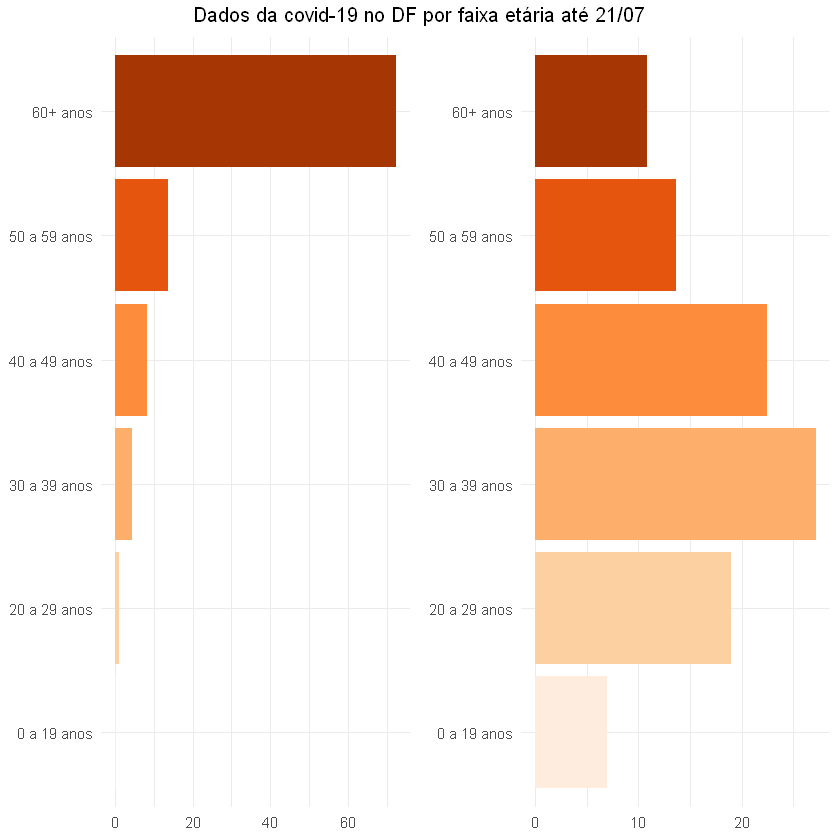

In [10]:
# TRATAR
#my_labels <- as.character(100 * df_FaixaEtaria$casos / sum(df_FaixaEtaria$casos))
#my_labels

# Representação percentual de cada faixa etária entre os óbitos
fx1 <- df_FaixaEtaria %>%
 filter(Obito == "Sim") %>%
 ggplot(aes(x = FaixaEtaria,
            weight = 100 * casos/sum(casos), 
            fill = FaixaEtaria)) +
 geom_bar(show.legend = FALSE) +
 scale_fill_brewer(palette = "Oranges") +
 coord_flip() +
 theme_minimal() +
 labs(x = NULL, y = NULL)


# Representação percentual de cada faixa etária na amostra total
fx2 <- df_FaixaEtaria %>%
 ggplot(aes(x = FaixaEtaria, fill = FaixaEtaria, weight = 100 * casos/sum(casos)), show.legend = FALSE) +
 geom_bar(show.legend = FALSE) +
 scale_fill_brewer(palette = "Oranges") +
 #geom_text(aes(x = FaixaEtaria, y = 100 * casos/sum(casos), 
               #label = paste(c(round(100 * casos/sum(casos), 1)), "%")),
           #vjust=0) +
 coord_flip() +
 theme_minimal() +
 labs(x = NULL, y = NULL)


# Plotando os dois gráficos juntos (biblioteca gridExtra)
#png("covid_genero.png", height=4, width=8, units="in", res=120)
grid.arrange(fx1, fx2, nrow=1,
            top = stringr::str_c("Dados da covid-19 no DF por faixa etária até ", last_update)) # Título
#dev.off()

### Taxa de mortalidade por gênero

Agora, iremos gerar as estatísticas agregadas pelo sexo declarado das pessoas.

In [11]:
df_Sexo <- df %>% 
  group_by(Sexo) %>%
  summarise(casos = n(),
            obitos = sum(Obito == "Sim"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos
            )

head(df_Sexo)

Sexo,casos,obitos,mortalidade,pct_comorbidade
Feminino,44600,480,0.01076233,0.10634529
Masculino,40161,666,0.01658325,0.09760713


Gerando o gráfico

[1] "A mortalidade observada entre as mulheres foi de 1.1%"
[1] "A mortalidade observada entre os homens foi de 1.7%"
[1] "A média da amostra completa foi de 1.4%"


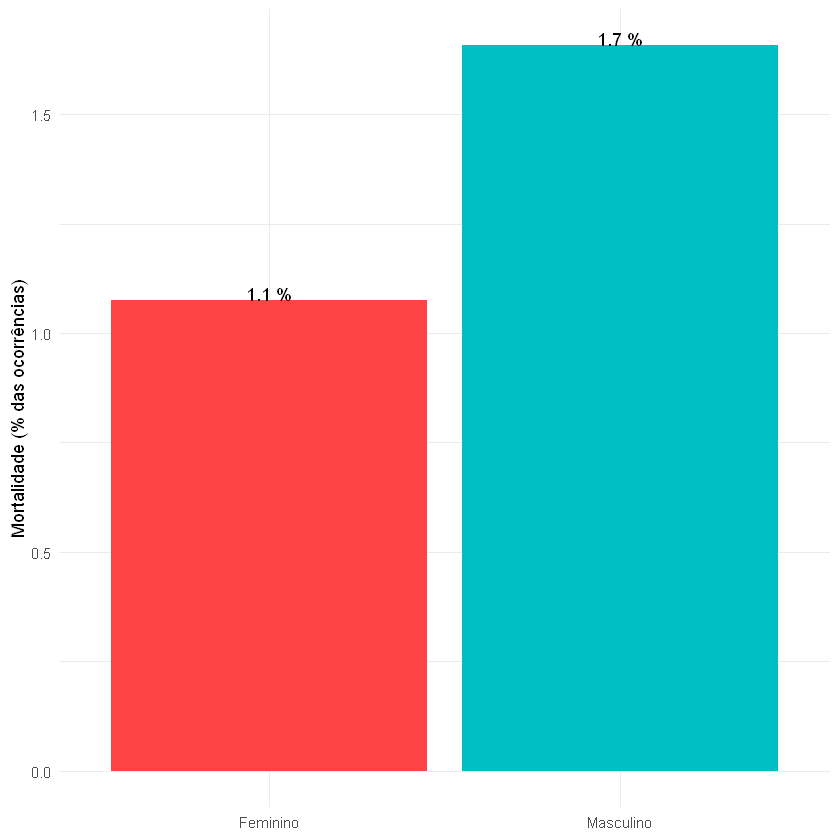

In [12]:
# Mortalidade por grupos
print(stringr::str_c("A mortalidade observada entre as mulheres foi de ", round(df_Sexo[1, 4] * 100, 1), "%"))
print(stringr::str_c("A mortalidade observada entre os homens foi de ", round(df_Sexo[2, 4] * 100, 1), "%"))
print(stringr::str_c("A média da amostra completa foi de ", 
                     round( 100 * sum(df_Sexo$obitos) / sum(df_Sexo$casos), 1), "%"))

# Gráfico de mortalidade
df_Sexo %>%
 ggplot(aes(x = Sexo, y = mortalidade * 100)) +
 geom_bar(stat = "identity", fill = c("#fd4343", "#00BFC4")) +
 geom_text(aes(x = Sexo, y = mortalidade * 100, 
               label = paste(c(round(mortalidade * 100, 1)), "%")),
           vjust=0) +
 labs(x = NULL, y = "Mortalidade (% das ocorrências)") + # Tira o rótulo do eixo x
 theme_minimal() # Fundo branco

#### Significância estatística da diferença

Veremos agora se essa diferença na mortalidade de mulheres e homens é estatisticamente significante. Isso será confirmado se o p-valor do teste de proporções for menor ou igual a 0.1 (10%).

In [13]:
# Teste bicaudal
our_test <- prop.test(df_Sexo$obitos, df_Sexo$casos, p = NULL, alternative = "two.sided",
          correct = FALSE)

our_test


	2-sample test for equality of proportions without continuity
	correction

data:  df_Sexo$obitos out of df_Sexo$casos
X-squared = 53.685, df = 1, p-value = 2.354e-13
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.007394739 -0.004247102
sample estimates:
    prop 1     prop 2 
0.01076233 0.01658325 


In [14]:
if (our_test$p.value > 0.10){
    print("De acordo com o p-valor do teste, essa diferença não é estatísticamente significante")
} else if (our_test$p.value > 0.05) {
    print("De acordo com o p-valor do teste, essa diferença é significante ao nível de 10%")
} else if (our_test$p.value > 0.01) {
    print("De acordo com o p-valor do teste, essa diferença é significante ao nível de 5%")
} else {
    print("De acordo com o p-valor do teste, essa diferença é significante ao nível de 1% (!!!)")
}

[1] "De acordo com o p-valor do teste, essa diferença é significante ao nível de 1% (!!!)"


### Mortalidade por Região Administrativa

Agora, analisaremos os dados agregados por Região Administrativa (RA). Primeiro iremos corrigir o nome da factor Águas Claras, e em seguida vamos agrupar os dados por RA. Por fim, criaremos o gráfico de taxa de mortalidade por RA.

In [15]:
# Retira o acento de "Águas Claras", para evitar problemas com ordem alfabética
df <- df %>%
  mutate(RA = ifelse(RA == "Águas Claras", "Aguas Claras", RA),
         RA = as.factor(RA))

# Agrupa os dados por RA
df_RA <- df %>% 
  group_by(RA) %>%
  summarise(casos = n(),
            obitos = sum(Obito == "Sim"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

head(df_RA)

RA,casos,obitos,mortalidade,pct_comorbidade,pct_mulheres,pct_homens
Aguas Claras,3223,24,0.007446478,0.06484642,0.5215638,0.4784362
Arniqueira,245,3,0.012244898,0.11020408,0.4938776,0.5061224
Brazlândia,1074,22,0.020484171,0.16480447,0.5558659,0.4441341
Candangolândia,556,7,0.012589928,0.16007194,0.5899281,0.4100719
Ceilândia,10269,224,0.021813224,0.11792774,0.5461097,0.4538903
Cruzeiro,694,4,0.005763689,0.09365994,0.5216138,0.4783862


Gerando agora o gráfico de mortalidade por Região Administrativa, excluídos os casos em que essa informação consta como "Não Informado" ou "Outros Estados"

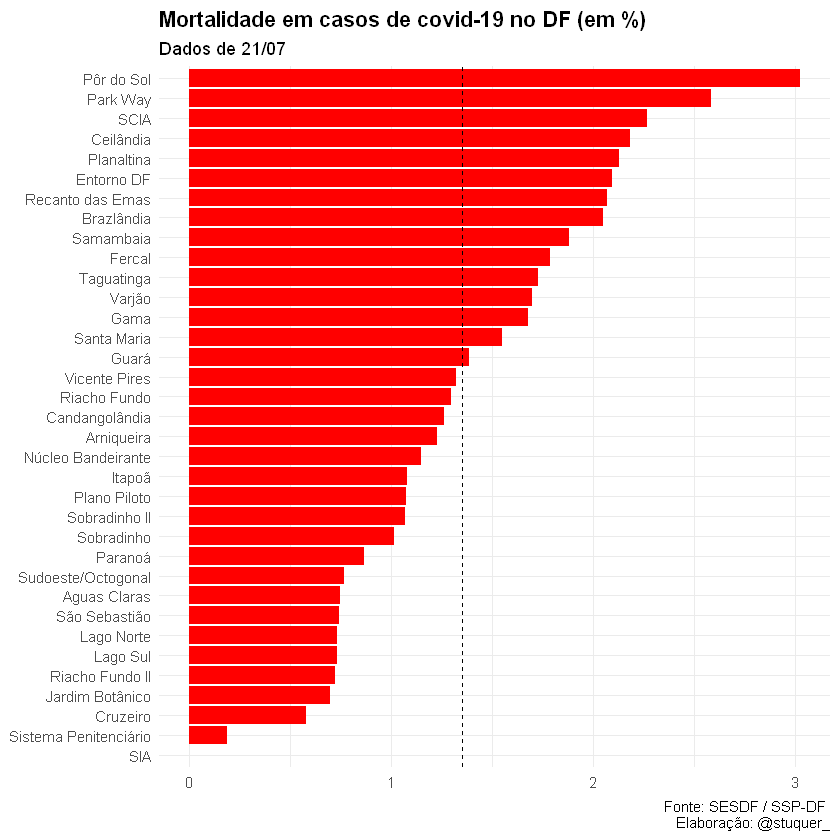

In [16]:
df_RA %>%
 filter(RA != "Não Informado", RA != "Outros Estados") %>%
 ggplot(aes(x = reorder(RA, mortalidade), y = mortalidade * 100)) +
 geom_bar(stat = "identity", fill = "red") +
 geom_hline(yintercept=(100* sum(df$Obito == "Sim") / nrow(df)), linetype="dashed", color = "black") + # Linha da média
 coord_flip() +  # Deixa o gráfico na horizontal
 theme_minimal() + # Fundo branco
 theme(plot.title = element_text(face = "bold")) + # Título em negrito
 labs(x = NULL, y = NULL,
      title = "Mortalidade em casos de covid-19 no DF (em %)",
      subtitle = stringr::str_c("Dados de ", last_update),
      caption = "Fonte: SESDF / SSP-DF \n Elaboração: @stuquer_") # Rodapé

### Evolução dos novos casos

Para concluir, faremos o agrupamento por dias.

In [17]:
# Estatísticas agregadas por data
df_Data <- df %>% 
  group_by(DataCadastro) %>%
  summarise(casos = n(),
            obitos = sum(Obito == "Sim"))

head(df_Data)

DataCadastro,casos,obitos
2020-03-01,1,0
2020-03-16,1,0
2020-03-17,1,0
2020-03-18,22,0
2020-03-19,41,0
2020-03-20,20,0


E finalmente, o gráfico com o número de novos casos por dia, bem como sua média móvel de 14 dias.

Warning message:
"package 'tidyquant' was built under R version 3.6.3"Loading required package: PerformanceAnalytics
Warning message:
"package 'PerformanceAnalytics' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.2"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend

Loading required package: quantmod
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
== Need to Learn tidyquant? =======================================

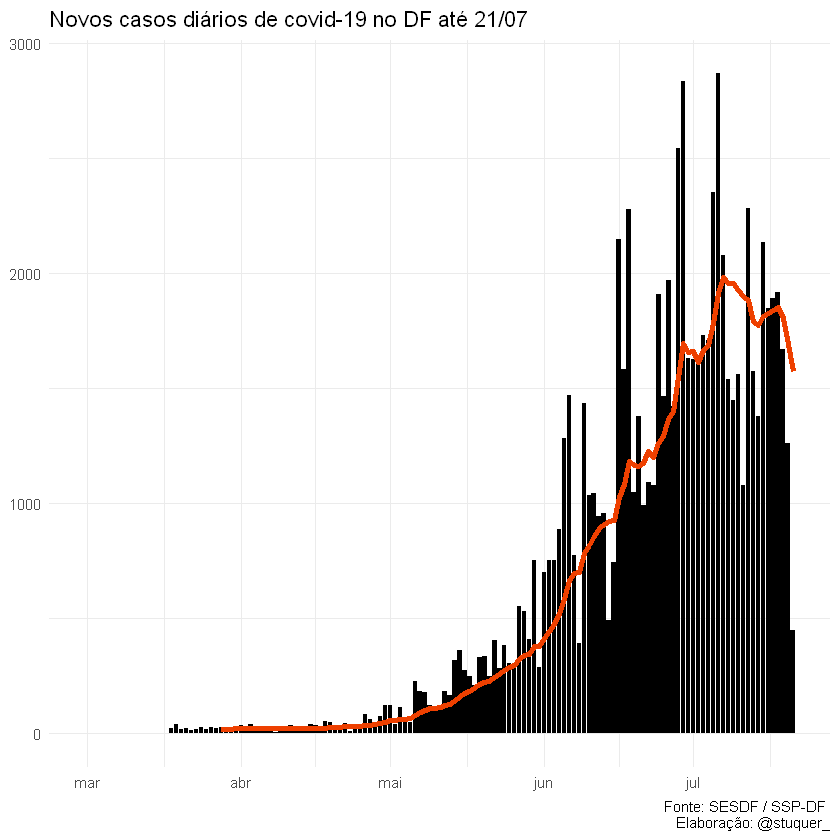

In [18]:
library(tidyquant) # Para médias móveis

# Novos casos, com média móvel para os últimos 14 dias
df_Data %>%
  ggplot(aes(x = DataCadastro, y = casos)) +
  geom_bar(stat = "identity", fill = "black") +
  geom_ma(ma_fun = SMA, n = 14, color = "orangered2", size = 1.5, linetype = "solid") +  # Média móvel
  theme_minimal() + # Fundo branco
  labs(x = NULL, y = NULL, # sem título pros eixos x e y
      title = stringr::str_c("Novos casos diários de covid-19 no DF até ", last_update),
      caption = "Fonte: SESDF / SSP-DF \n Elaboração: @stuquer_") # Rodapé